# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/) - само аналитическое разложение вам реализовывать НЕ НУЖНО

In [1]:
import random
import time
import torch
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from torch import nn
import torch
torch.manual_seed(0)
import tensorly as tl
tl.set_backend('pytorch')
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor

## 1 Создайте 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполните случайными целыми числами в диапазоне от 0 до 9.

Примечание: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работайте с типом *torch.Tensor.double*.

In [2]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor(size=(100,200,150),  r=(10,10,10)):
    G = torch.randint(0, 10,  (r[0], r[1], r[2])).double()
    data=G
    U = []
    i=0
    for mode in range(len(size)):
        U_mode = torch.randint(0, 10, (size[mode], r[i])).double()
        U.append(U_mode)
        i+=1
    data = torch.tensordot(U[0], data, dims=([1], [0]))
    data = torch.tensordot(U[1], data.permute([1, 0, 2]), dims=([1], [0]))
    data = data.permute([1, 0, 2])
    data = torch.tensordot(U[2], data.permute([2, 1, 0]), dims=([1], [0]))
    data = data.permute([2, 1, 0])
    return data, U, G

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [3]:
data, U, G = get_tensor((100, 200, 150), r=(10,10,10))
data.shape, [u.shape for u in U], G.shape

(torch.Size([100, 200, 150]),
 [torch.Size([100, 10]), torch.Size([200, 10]), torch.Size([150, 10])],
 torch.Size([10, 10, 10]))

In [4]:
noise = torch.randint(10, (data.shape))*1e-2
data += noise

Вопрос:
Почему задание не имеет смысла для полностью случайного тензора и зачем добавлять шум? *не отвечать нельзя*

Ответ:Если мы будем задавать случайно тензор, то там будет более белый шум. А если случайно задавать ядро и матрицы, то уже будет какая-то линейная зависимость.Получается если свосем случайно, то факторизация будет бесполезна потому что зависимостей просто не будет. Шум нужен из-за проблемы локальных минимумов.

## 2 Реализуйте метод для восстановления тензора по разложению

In [5]:
# Функция, восстанавливающая тензор по ядру и матрицам
def repair_tensor(G_, U):
    # data - восстановленный тензор из матриц и ядра
    # U - список матриц
    # G_ - ядро разложения
    data = G_
    for i in range(len(U)):
        numbers = list(range(G_.dim()))
        numbers[0], numbers[i] = numbers[i], numbers[0]
        data = torch.tensordot(U[i], data.permute(numbers), dims=([1], [0]))
        data = data.permute(numbers)
    return data

In [6]:
r1 = (10, 10, 10)
_, U1, G1 = get_tensor(size=(100, 200, 150), r=r1)
data1 = repair_tensor(G1, U1)
data1

tensor([[[391196., 240491., 427949.,  ..., 484914., 317361., 444838.],
         [355992., 212030., 382841.,  ..., 434238., 283499., 395766.],
         [302047., 190021., 331190.,  ..., 382868., 250698., 342781.],
         ...,
         [437404., 266366., 468995.,  ..., 538779., 354703., 491976.],
         [265587., 170152., 295414.,  ..., 336786., 219840., 303253.],
         [305985., 189582., 337558.,  ..., 386055., 249784., 352598.]],

        [[421714., 267235., 462961.,  ..., 533175., 352275., 480208.],
         [382943., 235669., 412822.,  ..., 476327., 317024., 431067.],
         [312447., 199715., 348214.,  ..., 404103., 262940., 358789.],
         ...,
         [462335., 287189., 502304.,  ..., 577464., 379490., 518856.],
         [276353., 181080., 309407.,  ..., 356475., 234583., 319343.],
         [326341., 207296., 364506.,  ..., 419285., 269834., 374717.]],

        [[518378., 326842., 553912.,  ..., 639855., 430007., 581615.],
         [464645., 284175., 492879.,  ..., 56

## 3 Сделайте разложение библиотечным методом
Пакет можете брать любой

In [7]:
import tensorly as tl
tl.set_backend('pytorch')
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
G2, U2 = tucker(data1, r1)
re_data1 = tucker_to_tensor((G2, U2))
mean_squared_error(data1.detach().numpy().flatten(), re_data1.detach().numpy().flatten())

1.1644858666972847e-19

Не забудьте померить ошибку разложения по метрике MSE

## 4 Реализуйте разложение градиентным методом

### 4.1 Реализуйте *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используйте квадратичный *Loss*.

In [8]:
import math
import torch
import torch.nn as nn 
from torch.optim.optimizer import Optimizer

class MyOptimizer(torch.optim.Optimizer): 
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999),  eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super().__init__(params, defaults)
        #self.weight_decay = weight_decay
  
    def step(self, closure=None ):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                
                if p.grad is None:
                    continue
                    
                grad = p.grad.data
                #if grad.is_sparse: 
                    #raise RuntimeError("Adam does not support sparse gradients") 
                state = self.state[p]
                # State initialization 
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values 
                    state['exp_avg'] = torch.zeros_like(p.data) 
                    # Exponential moving average of squared gradient values 
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1
                #if self.weight_decay != 0: 
                    #grad = grad.add(p.data, alpha=self.weight_decay) 
  
                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=(1 - beta1))
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=(1 - beta2))
                #bias_correction1 = 1 - beta1 ** state["step"] 
                #bias_correction2 = 1 - beta2 ** state["step"]
                #step_size = group["lr"] * math.sqrt(bias_correction2) / bias_correction1 
                exp_avg_hat = exp_avg / (1 - beta1 ** state['step'])
                exp_avg_sq_hat = exp_avg_sq / (1 - beta2 ** state['step'])
                
                
                denom = exp_avg_sq_hat.sqrt().add_(group['eps'])
                
        return loss

### 4.2 Реализуйте цикл оптимизации параметров

Стоит параметры оптимизировать сразу на GPU

In [9]:
r = (10, 10, 10)
size = (100, 100, 100)
data_train, U, G = get_tensor(size, r)
noise = torch.randint(10, (data_train.shape))*1e-3
data_train += noise
data_train = data_train.detach()

model =[nn.Parameter(G), nn.Parameter(U[0]), nn.Parameter(U[1]), nn.Parameter(U[2])]

loss_m = nn.MSELoss()
device=torch.device("cpu")
data=data_train.to(device)
for i in range(len(model)):
    model[i].to(device)
optimizer = MyOptimizer(model)
num_epochs = 1000
start_time = time.time()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    data_repair=repair_tensor(model[0], [model[1], model[2], model[3]])
    mse_loss=loss_m(data_repair, data)
    mse_loss.backward()
    optimizer.step()
end_time = time.time()
total_time = end_time - start_time
print(f"Time {total_time:.2f} ")
print('MSE', mse_loss)

Time 11.46 
MSE tensor(2.8516e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)


## 5 Приведите сравнение скорости работы и ошибки восстановления методом из пакета и реализованного градиентного
Сравнение может считаться ± объективным с размером выборки от 10.

In [10]:
def pack(G,U, data, mse_calculator):
    start_time = time.time()
    tensor=tucker_to_tensor((G, U))
    mse_calculator = torch.nn.MSELoss()
    loss = mse_calculator(tensor, data).item()
    end_time = time.time()
    return loss, end_time - start_time

In [11]:
mse_analitic=[]
mse_my=[]
time_analitic=[]
time_my=[]
for i in range(10):
    size=(100,100,100)
    r=(10,10,10)
    mse_calculator = torch.nn.MSELoss()
    data, U, G = get_tensor(size, r)
    data += noise
    data = data.detach()
    losses, times = pack(G, U, data, mse_calculator)
    mse_analitic.append(losses)
    time_analitic.append(times)
    
    model =[nn.Parameter(G), nn.Parameter(U[0]), nn.Parameter(U[1]), nn.Parameter(U[2])]
    device=torch.device("cpu")
    noise = torch.randint(10, (data.shape))*1e-3
    data += noise
    data = data.detach()
    data = data.to(device)
    num_epochs = 100
    for i in range(len(model)):
        model[i].to(device)
    optimizer = MyOptimizer(model)
    start_time=time.time()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        r=repair_tensor(model[0], [model[1], model[2], model[3]])
        mse_loss=mse_calculator(r, data)
        mse_loss.backward()
        optimizer.step()
    end_time=time.time()
    time_my.append(end_time-start_time)
    mse_my.append( mean_squared_error(r.detach().numpy().flatten(), data.detach().numpy().flatten()))

In [12]:
print(mse_analitic)
print(mse_my)
print(time_analitic)
print(time_my)

[2.85162525239655e-05, 2.8548007527319668e-05, 2.8527125525104782e-05, 2.847619751815138e-05, 2.851625452195799e-05, 2.8487641519640138e-05, 2.8457716517352715e-05, 2.8528828523399727e-05, 2.8547556528375785e-05, 2.850674452179383e-05]
[9.761930148631755e-05, 9.765493849027267e-05, 9.752757847479895e-05, 9.751046946888844e-05, 9.755817547470085e-05, 9.741241346363134e-05, 9.749990647053903e-05, 9.763531848674849e-05, 9.757001248154531e-05, 9.751982446873616e-05]
[0.005001544952392578, 0.00299835205078125, 0.0030045509338378906, 0.002996206283569336, 0.0019936561584472656, 0.002000570297241211, 0.0030002593994140625, 0.0035400390625, 0.0030002593994140625, 0.002000570297241211]
[1.2317838668823242, 1.2066693305969238, 1.1118974685668945, 1.0939466953277588, 1.063140630722046, 1.124406337738037, 1.2799365520477295, 1.1215097904205322, 1.0862112045288086, 1.0781877040863037]


In [13]:
print(min(mse_analitic),min(mse_my))

2.8457716517352715e-05 9.741241346363134e-05


In [14]:
print(min(time_analitic),min(time_my))

0.0019936561584472656 1.063140630722046


In [15]:
print(np.mean(mse_analitic), np.mean(mse_my))

2.851123252270615e-05 9.755079387661789e-05


In [16]:
print(np.mean(time_analitic), np.mean(time_my))

0.0029536008834838865 1.1397689580917358


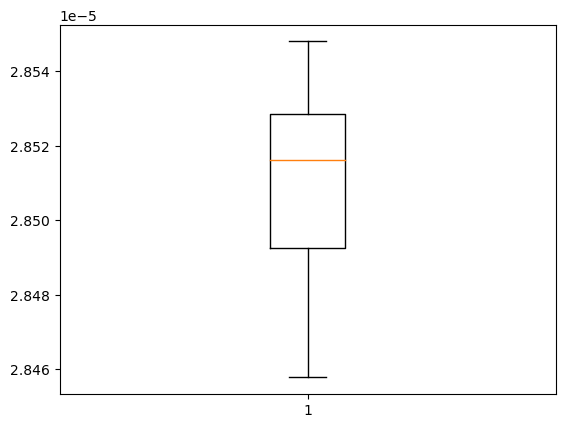

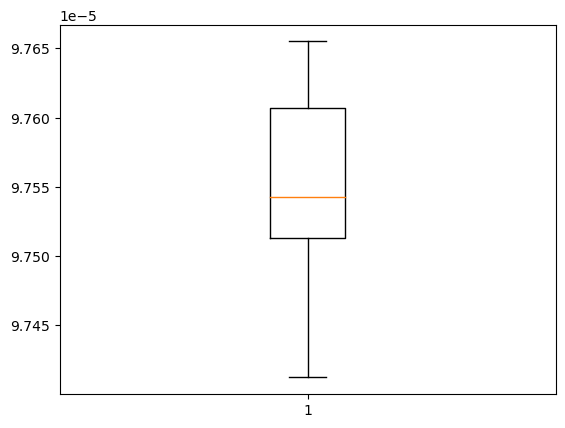

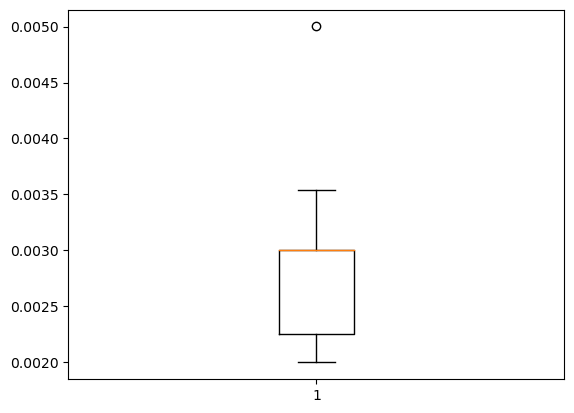

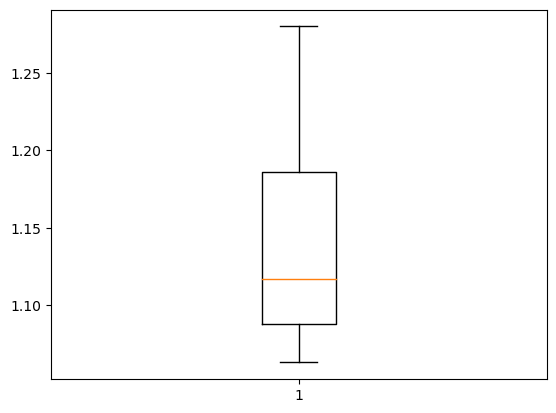

In [17]:
import matplotlib.pyplot as plt
plt.boxplot(mse_analitic)
plt.show()
plt.boxplot(mse_my)
plt.show()
plt.boxplot(time_analitic)
plt.show()
plt.boxplot(time_my)
plt.show()

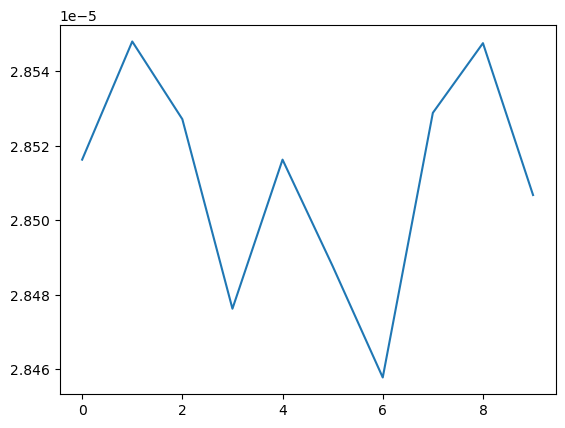

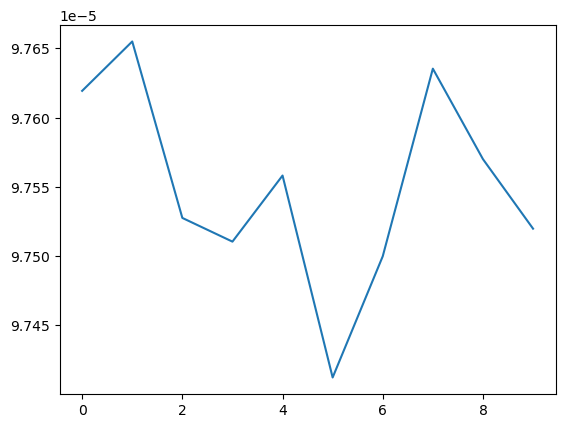

In [18]:
plt.plot(mse_analitic)
plt.show()
plt.plot(mse_my)
plt.show()